In [1]:
using DifferentialEquations
using Plots
using LinearAlgebra
import ForwardDiff
import DiffResults
using AstrodynamicsBase
using Printf
using JSON
using CSV
using DataFrames
using ColorSchemes
using LaTeXStrings

In [32]:
include("../src/SailorMoon.jl")   # relative path to main file of module
param3b = SailorMoon.dynamics_parameters()
paramMulti = SailorMoon.multi_shoot_parameters(param3b)
gr()
fs = 16


┌ Warning: Replacing docs for `Main.SailorMoon.integrate_rk4 :: Union{Tuple{ODEProblem, Real}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}, Bool}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}, Bool, Bool}}` in module `Main.SailorMoon`
└ @ Base.Docs docs\Docs.jl:240


16

In [22]:
function plot_circle(radius, x, y, n=100)
    circle = zeros(2,n)
    thetas = LinRange(0.0, 2π, n)
    for i = 1:n
        circle[1,i] = radius*cos(thetas[i]) + x
        circle[2,i] = radius*sin(thetas[i]) + y
    end
    return circle
end

plot_circle (generic function with 2 methods)

In [23]:
moon     = SailorMoon.plot_circle((1-param3b.mu2)*param3b.lstar, 0.0, 0.0)
earth    = SailorMoon.plot_circle(param3b.mu2*param3b.lstar, 0.0, 0.0)
earth_ub = SailorMoon.plot_circle(param3b.mu2*param3b.lstar+6375,0.0, 0.0)
earth_lb = SailorMoon.plot_circle(param3b.mu2*param3b.lstar-6375, 0.0, 0.0)
moon_soi_outer = plot_circle((1-param3b.mu2)*param3b.lstar+66000, 0.0, 0.0);

In [24]:
function interpolatecolor(cs,value, vmin, vmax)
    cs = cgrad(cs)
    color = cs[(value - vmin) / (vmax - vmin)]
    return color
end

interpolatecolor (generic function with 1 method)

In [25]:
### PARAMETERS ###################################
# csv file to load the initial solution
filename = "../run/data/diffcorr_0619_NoThrust.csv"
# dv_dir function corresponding to the csv file 
dir_func = SailorMoon.dv_no_thrust

n_arc = 5

cs = :lightrainbow 
##################################################

if dir_func == SailorMoon.dv_no_thrust
    τ_ig = 0.0
else 
    τ_ig = 1.0
end

# load initial guess
df = CSV.read(filename, DataFrame; header=0);

arcs_color = Dict(
    "xlr_bck_arc" => :blue, 
    "xlr_fwd_arc" => :red,
    "mid_bck_arc" => :green, 
    "mid_fwd_arc" => :black, 
    "lpo_arc" => :yellow
)






Dict{String, Symbol} with 5 entries:
  "lpo_arc"     => :yellow
  "xlr_bck_arc" => :blue
  "xlr_fwd_arc" => :red
  "mid_fwd_arc" => :black
  "mid_bck_arc" => :green

In [26]:
p_ = plot(
    size=(700,500), 
    frame_style=:box, aspect_ratio=:equal, grid=0.4, 
    legend=false, 
    xlabel=L"t", ylabel=L"val",
    colorbar_titlefontsize=fs,
    fontsize=fs, xlabelfontsize=fs, ylabelfontsize=fs, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-1
);


tofs= [row[1] for row in eachrow( df ) ] 
tof_max = maximum(tofs)
tof_min = minimum(tofs)

tof_max_days = tof_max * param3b.tstar / (24*60*60)
tof_min_days = tof_min * param3b.tstar / (24*60*60)

colors = [interpolatecolor(cs, row[1], tof_min, tof_max) for row in eachrow(df)]

u = []
t = []

# for (i, row) in enumerate( eachrow( df ) ) 
    
row = df[1,:]

    x = collect(values(row[4:end]))
#     println(x)
    
#     color = colors[i]
    res, sol_param_list, sols_ballistic, tofs = SailorMoon.multishoot_trajectory2(x, dir_func, paramMulti, true, false)
        
    # ballistic legs
    for sol_ballistic in sols_ballistic

        u = vcat(sol_ballistic.u[:])
        t = vcat(sol_ballistic.t[:])
        
    end
    
    for j = 1:Int(floor(length(sol_param_list)/paramMulti.n_arc))
        
        for k = 1:paramMulti.n_arc
                        
            if mod(j,2) == 1
                # backward propagation
                sol, _, name = sol_param_list[length(sol_param_list) - j*paramMulti.n_arc + k]
                u = vcat(u, sol.u[:])
                t_append = sol.t[:] .+ t[end]
                t = vcat(t, t_append)
                
            else
                # forward propagation
                sol, _, name = sol_param_list[length(sol_param_list)-(j-1)*paramMulti.n_arc - k + 1]
                u_append = sol.u[end:-1:1, :]
                t_append = sol.t[end:-1:1] .- sol.t[end] .+ t[end]
                u = vcat(u, u_append)
                t = vcat(t, t_append)
            end

        end
        
    end
    
# end
u = Array(u)
u = hcat(u...)[:,:]


7×1368 Matrix{Float64}:
 387.699        387.699        387.699        …  388.796        388.796
  -0.00258706    -0.000507767    0.00273733        0.00689439     0.00694764
   5.58283e-23    5.5827e-23     5.58232e-23       1.90533e-25    1.89162e-25
   0.00283365     0.000698255   -0.00263434       -6.68591       -6.70131
  -1.20381       -1.20381       -1.20379          -8.00391       -7.99105
   4.43061e-25    9.86703e-25    1.83509e-24  …    2.0566e-22     2.05871e-22
   1.0            1.0            1.0               1.0            1.0

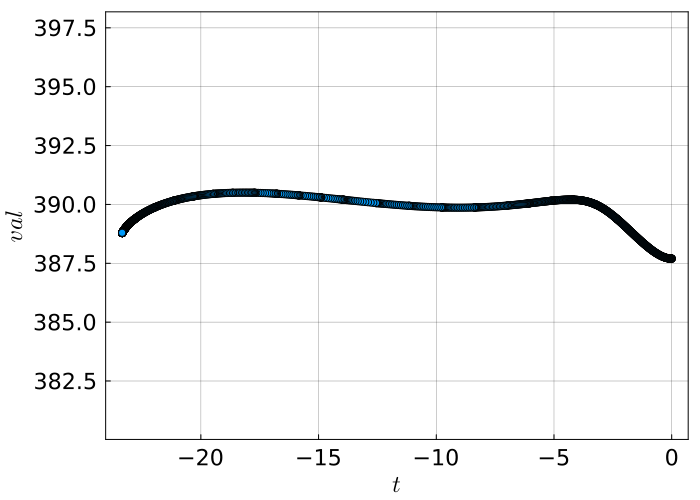

In [27]:
scatter!(p_, t[:], u[1,:])


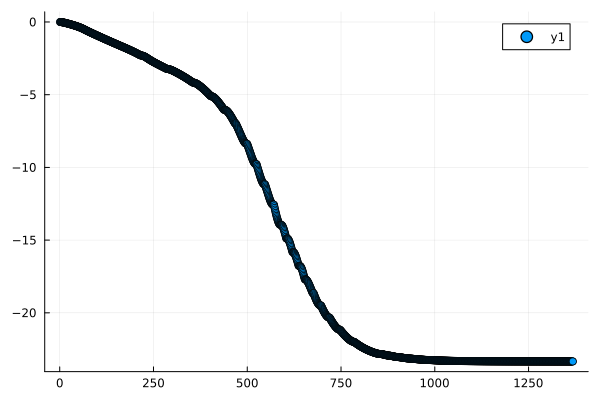

In [28]:
scatter(collect(1:1368),t)

In [33]:
## test 
t_, u_  = SailorMoon.x2time_series(x, dir_func, paramMulti)


([0.0, -0.0017272654398015593, -0.00442297428730376, -0.007192689542999883, -0.010733154820595918, -0.014664004381718727, -0.019080870713698857, -0.02385664516028952, -0.028993363147893948, -0.03441433610330669  …  -23.343664358517408, -23.34368725191045, -23.343710385003142, -23.34373337083151, -23.343756373294415, -23.34377931146358, -23.34380225976438, -23.343825044696874, -23.34384808839187, -23.343854747143812], [387.69855334505826 387.6985502947908 … 388.7961165184733 388.79616108960107; -0.0025870603240320967 -0.0005077670155954963 … 0.00689439026743583 0.006947643527734119; … ; 4.430609038444866e-25 9.867026929524208e-25 … 2.0566005293882402e-22 2.058706249640412e-22; 1.0 1.0 … 1.0000000000512108 1.0000000000512108])

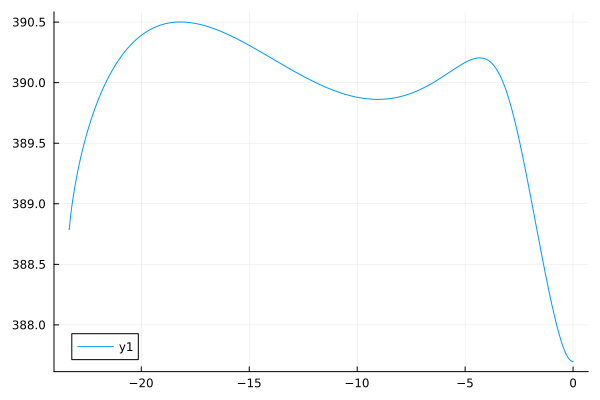

In [34]:
plot(t_, u_[1,:])

In [35]:
# compute JC from state in EMrot
function compute_JC(state::Vector)
    x, y, z = state[1], state[2], state[3]
    vx, vy, vz = state[4], state[5], state[6]
    r13 = norm([x-param3b.mu2, y, z])  # Earth - SC
    r23 = norm([x-param3b.mu1, y, z])  # Moon - SC
    
    U = 1/2*(x^2+y^2) + param3b.mu1 / r13 + param3b.mu2 / r23 
    JC = 2*U - (vx^2 + vy^2 + vz^2)
    
    return JC 
end

compute_JC (generic function with 1 method)

In [38]:
θlpo = x[19+12*paramMulti.n_arc]

-0.00251131061131133

In [93]:
u_emrots = []
JC_vec = []

for (i, tnow) in enumerate(t_)
    θm = θlpo - param3b.oml * tnow
    u_sb1   = u_[1:6,i]
    u_emrot = SailorMoon.transform_SunB1_to_EMrot(u_sb1, θm, param3b.oml, param3b.as)
    u_emrots = push!(u_emrots, transpose(u_emrot))
    
    jc = compute_JC(u_emrot)
    push!(JC_vec, jc)
end
u_emrots = Array(reshape(hcat(u_emrots...), 6, size(u_emrots,1)))



6×1368 Matrix{Float64}:
 -1.12268      -1.12269      -1.12268      …  0.0258376    0.025817
 -0.00540646   -0.00153306    0.0045121       0.00332778   0.0032613
  5.58283e-23   5.5827e-23    5.58232e-23     1.90533e-25  1.89162e-25
  0.000854712   0.000379241  -0.000362731     3.0849       3.10407
 -0.165096     -0.165094     -0.165085        9.93935      9.93341
  4.43061e-25   9.86703e-25   1.83509e-24  …  2.0566e-22   2.05871e-22

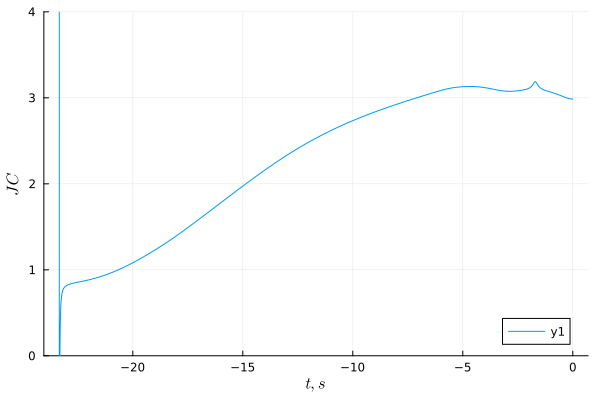

In [97]:
plot(t_, JC_vec, ylim=[0,4], xlabel=L"t,s", ylabel=L"JC")

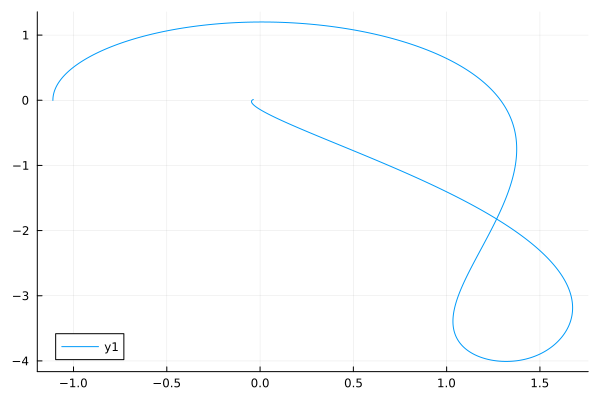

In [85]:
u_emrots = Array(reshape(hcat(u_emrots...), 6, size(u_emrots,1)))
plot(u_emrots[1,:], u_emrots[2,:])
